
Nineth exercice: non-Cartesian MR image reconstruction
=============================================
In this tutorial we will reconstruct an MRI image from radial undersampled kspace measurements. Let us denote $\Omega$ the undersampling mask, the under-sampled Fourier transform now reads $F_{\Omega}$.

Import neuroimaging data
--------------------------------------
We use the toy datasets available in pysap, more specifically a 2D brain slice and the radial under-sampling scheme. We compare zero-order image reconstruction with Compressed sensing reconstructions (analysis vs synthesis formulation) using the FISTA algorithm for the synthesis formulation and the Condat-Vu algorithm for the analysis formulation.

We remind that the synthesis formulation reads (minimization in the sparsifying domain):
$$
\widehat{z} = \text{arg}\,\min_{z\in C^n_\Psi} \frac{1}{2} \|y - F_\Omega  \Psi^*z \|_2^2 + \lambda \|z\|_1
$$
and the image solution is given by $\widehat{x} = \Psi^*\widehat{z}$. For an orthonormal wavelet transform, 
we have $n_\Psi=n$ while for a frame we may have $n_\Psi > n$.

while the analysis formulation consists in minimizing the following cost function (min. in the image domain):
$$
\widehat{x} = \text{arg}\,\min_{x\in C^n} \frac{1}{2} \|y - F_\Omega x\|_2^2 + \lambda \|\Psi x\|_1 \,.
$$

- Author: Chaithya G R & Philippe Ciuciu
- Date: 01/06/2021 
- Target: ATSI MSc students, Paris-Saclay University

In [1]:
# Package import
from mri.operators import NonCartesianFFT, WaveletN, WaveletUD2
from mri.operators.utils import convert_locations_to_mask, \
    gridded_inverse_fourier_transform_nd
from mri.reconstructors import SingleChannelReconstructor
import pysap
from pysap.data import get_sample_data

# Third party import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold
import numpy as np
import matplotlib.pyplot as plt

/home/ciuciu/anaconda3/lib/python3.7/site-packages/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/ciuciu/anaconda3/lib/python3.7/site-packages/mri/operators/fourier/non_cartesian.py:42: UserWarning: gpuNUFFT python package has not been found. If needed please check on how to install in README
  warnings.warn("gpuNUFFT python package has not been found. If needed "


Loading input data
---------------------------

/home/ciuciu/anaconda3/lib/python3.7/site-packages/mri/operators/fourier/utils.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


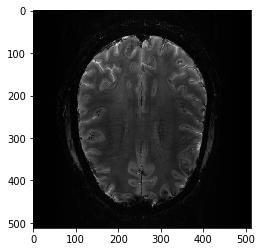

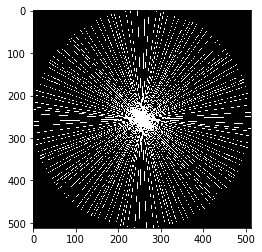

In [2]:
image = get_sample_data('2d-mri')
radial_mask = get_sample_data("mri-radial-samples")
kspace_loc = radial_mask.data
mask = pysap.Image(data=convert_locations_to_mask(kspace_loc, image.shape))
plt.figure()
plt.imshow(image, cmap='gray')
plt.figure()
plt.imshow(mask, cmap='gray')
plt.show()

Generate the kspace
-------------------

From the 2D brain slice and the acquisition mask, we retrospectively
undersample the k-space using a cartesian acquisition mask
We then reconstruct the zero order solution as a baseline

Get the locations of the kspace samples

In [3]:
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=image.shape,
                             implementation='cpu')
kspace_obs = fourier_op.op(image.data)

Gridded solution

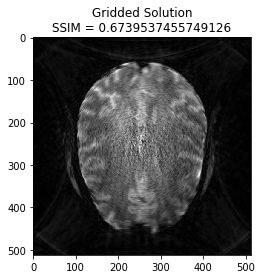

In [4]:
grid_space = np.linspace(-0.5, 0.5, num=image.shape[0])
grid2D = np.meshgrid(grid_space, grid_space)
grid_soln = gridded_inverse_fourier_transform_nd(kspace_loc, kspace_obs,
                                                 tuple(grid2D), 'linear')
plt.imshow(np.abs(grid_soln), cmap='gray')
# Calculate SSIM
base_ssim = ssim(grid_soln, image)
plt.title('Gridded Solution\nSSIM = ' + str(base_ssim))
plt.show()

FISTA optimization
------------------

We now want to refine the zero order solution using a FISTA optimization.
The cost function is set to Proximity Cost + Gradient Cost

In [5]:
linear_op = WaveletN(wavelet_name="sym8", nb_scales=4)
regularizer_op = SparseThreshold(Identity(), 6 * 1e-7, thresh_type="soft")

# Generate operators

In [6]:
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    verbose=1,
)

Lipschitz constant is 570.4522582982656
The lipschitz constraint is satisfied


Synthesis formulation: FISTA optimization
------------------------------------------------------------

We now want to refine the zero order solution using a FISTA optimization.
The cost function is set to Proximity Cost + Gradient Cost

N/A% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - mu:  6e-07
 - lipschitz constant:  570.4522582982656
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7fd8c5170ed0> - 4
 - max iterations:  200
 - image variable shape:  (512, 512)
 - alpha variable shape:  (291721,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:28 Time:  0:00:28


 - final iteration number:  200
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  28.90419067896437  seconds
----------------------------------------


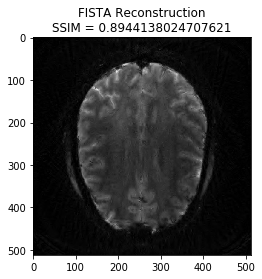

In [8]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='fista',
    num_iterations=200,
)
image_rec = pysap.Image(data=np.abs(x_final))
recon_ssim = ssim(image_rec, image)
plt.imshow(np.abs(image_rec), cmap='gray')
recon_ssim = ssim(image_rec, image)
plt.title('FISTA Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()

## POGM reconstruction

 - mu:  6e-07
 - lipschitz constant:  570.4522582982656
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7fd8c5170ed0> - 4
 - max iterations:  200
 - image variable shape:  (1, 512, 512)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:31 Time:  0:00:31


 - final iteration number:  200
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  31.568309169029817  seconds
----------------------------------------


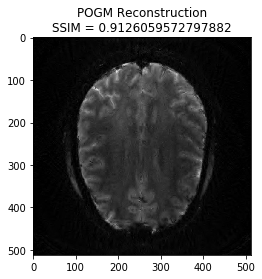

In [9]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='pogm',
    num_iterations=200,
)
image_rec = pysap.Image(data=np.abs(x_final))
recon_ssim = ssim(image_rec, image)
plt.imshow(np.abs(image_rec), cmap='gray')
recon_ssim = ssim(image_rec, image)
plt.title('POGM Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()

Analysis formulation: Condat-Vu reconstruction 
---------------------------------------------------------------------

In [13]:
#linear_op = WaveletN(wavelet_name="sym8", nb_scales=4)
linear_op = WaveletUD2(
    wavelet_id=24,
    nb_scale=4,
)

In [14]:
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='analysis',
    verbose=1,
)

Lipschitz constant is 570.452258225419
The lipschitz constraint is satisfied


 - mu:  6e-07
 - lipschitz constant:  570.452258225419
 - tau:  0.003499650305671012
 - sigma:  0.5
 - rho:  1.0
 - std:  None
 - 1/tau - sigma||L||^2 >= beta/2:  True
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletUD2 object at 0x7fd8c528ba90> - 4
 - max iterations:  200
 - number of reweights:  0
 - primal variable shape:  (512, 512)
 - dual variable shape:  (2621440,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:03:28 Time:  0:03:28


 - final iteration number:  200
 - final cost value:  1000000.0
 - converged:  False
Done.
Execution time:  210.95389512297697  seconds
----------------------------------------


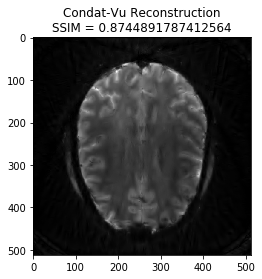

In [15]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='condatvu',
    num_iterations=200,
)
image_rec = pysap.Image(data=np.abs(x_final))
plt.imshow(np.abs(image_rec), cmap='gray')
recon_ssim = ssim(image_rec, image)
plt.title('Condat-Vu Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()
